# Fair AI with COMPAS Dataset

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
results_dir = "../results"
def save_plot(filename):
    filepath = os.path.join(results_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

## Data Loading & Initial Exploration

In [2]:
# compas scores raw
df_compas = pd.read_csv("../data/compas-scores-raw.csv")
print(f"Shape compas-scores-raw: {df_compas.shape}")
print(f"Columns: {df_compas.columns.tolist()}")
df_compas.head()

Shape compas-scores-raw: (60843, 28)
Columns: ['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText', 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted', 'IsDeleted']


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [3]:
# Cox Violent Parsed Dataset
df_cox = pd.read_csv("../data/cox-violent-parsed.csv")
print(f"Shape cox-violent-parsed: {df_cox.shape}")
print(f"Columns: {df_cox.columns.tolist()}")
df_cox.head()

Shape cox-violent-parsed: (18316, 52)
Columns: ['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event']


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [4]:
# Cox Violent Parsed Filtered Dataset
df_cox_filt = pd.read_csv("../data/cox-violent-parsed_filt.csv")
print(f"Shape cox-violent-parsed_filt: {df_cox_filt.shape}")
print(f"Columns: {df_cox_filt.columns.tolist()}")
df_cox_filt.head()

Shape cox-violent-parsed_filt: (18316, 40)
Columns: ['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'priors_count.1', 'event']


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [5]:
# propublica data
df_propublica = pd.read_csv("../data/propublica_data_for_fairml.csv")
print(f"Shape propublica_data_for_fairml: {df_propublica.shape}")
print(f"Columns: {df_propublica.columns.tolist()}")
df_propublica.head()

Shape propublica_data_for_fairml: (6172, 12)
Columns: ['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Other', 'Female', 'Misdemeanor']


,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [6]:
# Matched Columns between datasets
print("Matched Columns:")
compas_cols = set(df_compas.columns)
cox_cols = set(df_cox.columns)
cox_filt_cols = set(df_cox_filt.columns)
propublica_cols = set(df_propublica.columns)

print(f" - COMPAS y Cox: {compas_cols.intersection(cox_cols)}")
print(f" - Cox y Cox filtered: {cox_cols.intersection(cox_filt_cols)}")
print(f" - ProPublica y Cox: {propublica_cols.intersection(cox_cols)}")

Matched Columns:
 - COMPAS y Cox: set()
 - Cox y Cox filtered: {'race', 'r_charge_desc', 'first', 'c_charge_desc', 'type_of_assessment', 'vr_charge_degree', 'r_offense_date', 'vr_offense_date', 'juv_other_count', 'days_b_screening_arrest', 'decile_score.1', 'id', 'v_score_text', 'priors_count', 'r_days_from_arrest', 'priors_count.1', 'last', 'c_days_from_compas', 'dob', 'is_violent_recid', 'r_jail_in', 'v_decile_score', 'decile_score', 'name', 'vr_charge_desc', 'is_recid', 'juv_fel_count', 'age_cat', 'screening_date', 'sex', 'c_charge_degree', 'score_text', 'c_jail_in', 'event', 'violent_recid', 'juv_misd_count', 'v_type_of_assessment', 'age', 'r_charge_degree', 'c_jail_out'}
 - ProPublica y Cox: set()


## Exploratory Data Analysis (EDA)
The best for EDA and fairness analysis is the ProPublica preprocessed dataset (`propublica_data_for_fairml.csv`) because it already highlights sensitive attributes (race, sex, age groups). Also, it’s smaller, cleaner, and directly highlights fairness issues.

In [2]:
df = pd.read_csv("../data/propublica_data_for_fairml.csv")

In [3]:
# Dataset info
print("\n--- Dataset Info ---")
print(df.info())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB
None

--- Missing Values ---
Two_yr_Recidivism       0
Number_of_Priors        0
score_factor            0
Age_Above_FourtyFive    0
Age_Below_T

--- Target Distribution ---
Two_yr_Recidivism
0    0.54488
1    0.45512
Name: proportion, dtype: float64


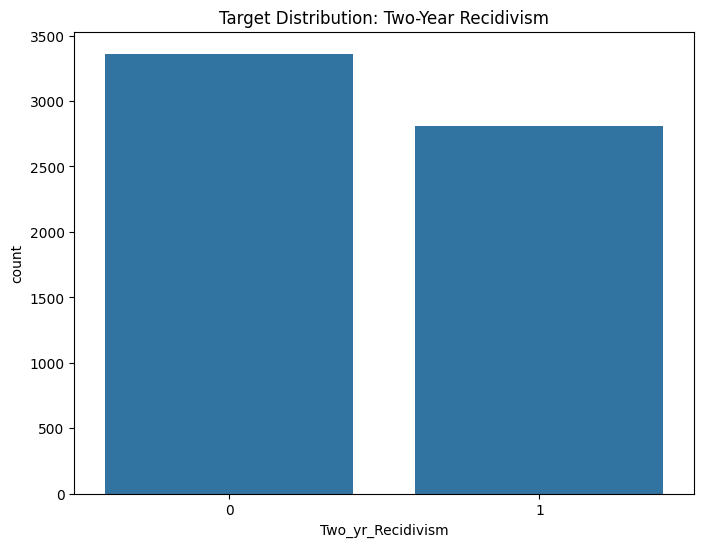

In [14]:
# Target: Two-year recidivism
print("--- Target Distribution ---")
print(df['Two_yr_Recidivism'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Two_yr_Recidivism")
plt.title("Target Distribution: Two-Year Recidivism")
save_plot("target_distribution.png")
plt.show()

--- Race Distribution ---
Race_Group
African_American    0.855152
Hispanic            0.082469
Other               0.055574
Asian               0.005023
Native_American     0.001782
Name: proportion, dtype: float64


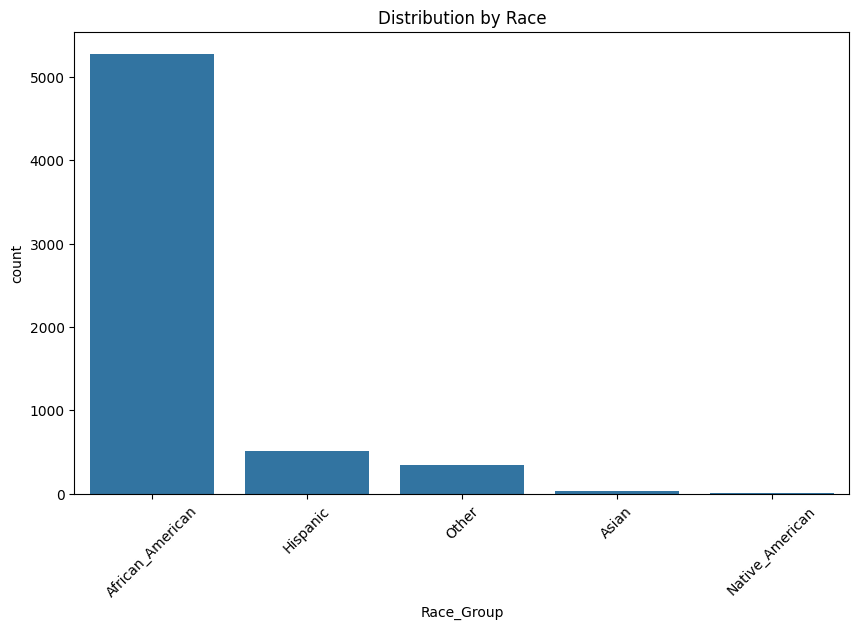

In [15]:
# Race distribution
race_cols = ['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']
df['Race_Group'] = df[race_cols].idxmax(axis=1)

print("--- Race Distribution ---")
print(df['Race_Group'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Race_Group", order=df['Race_Group'].value_counts().index)
plt.title("Distribution by Race")
plt.xticks(rotation=45)
save_plot("race_distribution.png")
plt.show()

--- Gender Distribution ---
Female
0    0.809624
1    0.190376
Name: proportion, dtype: float64


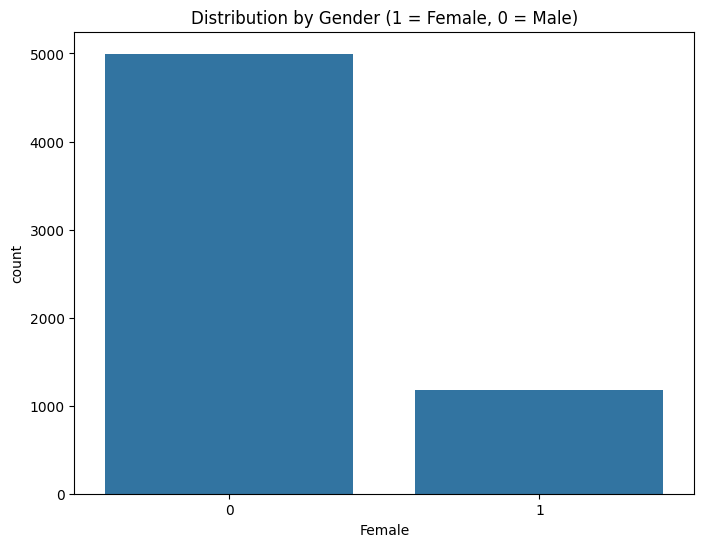

In [16]:
# Gender distribution
print("--- Gender Distribution ---")
print(df['Female'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Female")
plt.title("Distribution by Gender (1 = Female, 0 = Male)")
save_plot("gender_distribution.png")
plt.show()

--- Age Distribution ---
Age_Group
25-45       0.572262
Below 25    0.218244
Above 45    0.209494
Name: proportion, dtype: float64


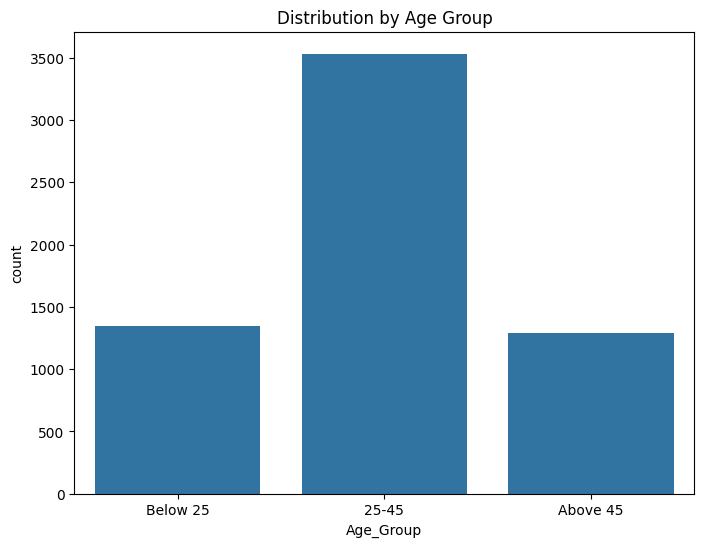

In [17]:
# Age groups
age_cols = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive']
def get_age_group(row):
    if row['Age_Below_TwentyFive'] == 1:
        return 'Below 25'
    elif row['Age_Above_FourtyFive'] == 1:
        return 'Above 45'
    else:
        return '25-45'

df['Age_Group'] = df.apply(get_age_group, axis=1)

print("--- Age Distribution ---")
print(df['Age_Group'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Age_Group", order=['Below 25','25-45','Above 45'])
plt.title("Distribution by Age Group")
save_plot("age_distribution.png")
plt.show()

--- Recidivism Rate by Race ---
 Race_Group
African_American    0.470443
Asian               0.258065
Hispanic            0.371316
Native_American     0.454545
Other               0.361516
Name: Two_yr_Recidivism, dtype: float64


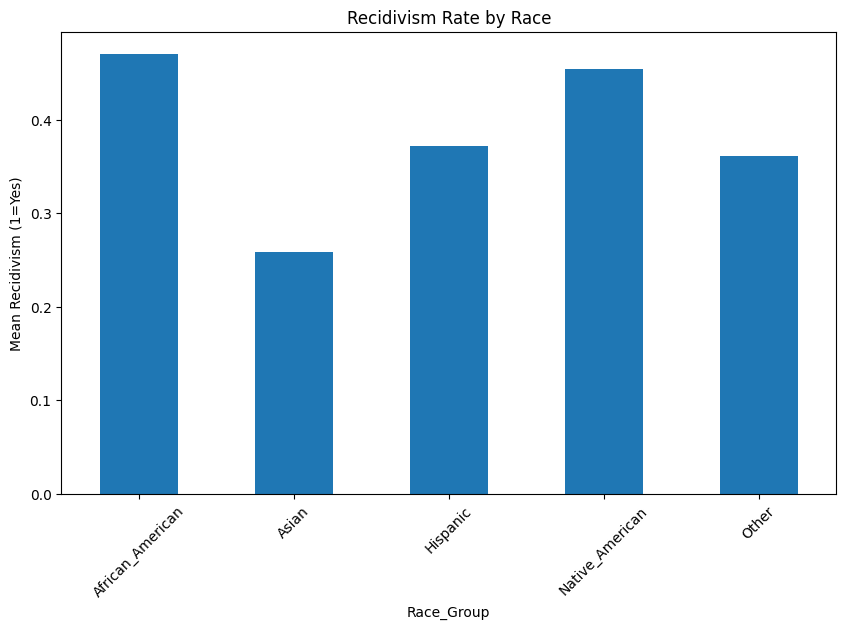

In [18]:
# Recidivism by Race
race_recid = df.groupby('Race_Group')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Race ---\n", race_recid)

plt.figure(figsize=(10, 6))
race_recid.plot(kind='bar')
plt.title("Recidivism Rate by Race")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=45)
save_plot("recidivism_by_race.png")
plt.show()

--- Recidivism Rate by Gender ---
 Female
0    0.479488
1    0.351489
Name: Two_yr_Recidivism, dtype: float64


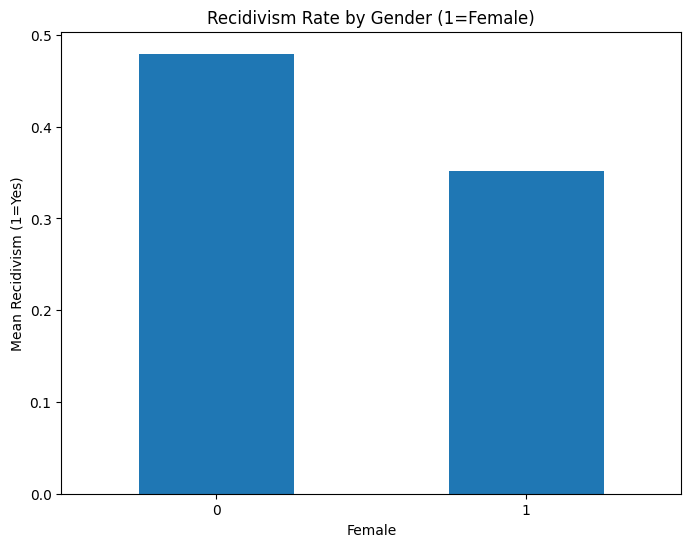

In [19]:
# Recidivism by Gender
gender_recid = df.groupby('Female')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Gender ---\n", gender_recid)

plt.figure(figsize=(8, 6))
gender_recid.plot(kind='bar')
plt.title("Recidivism Rate by Gender (1=Female)")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=0)
save_plot("recidivism_by_gender.png")
plt.show()

--- Recidivism Rate by Age Group ---
 Age_Group
25-45       0.464609
Above 45    0.320186
Below 25    0.559762
Name: Two_yr_Recidivism, dtype: float64


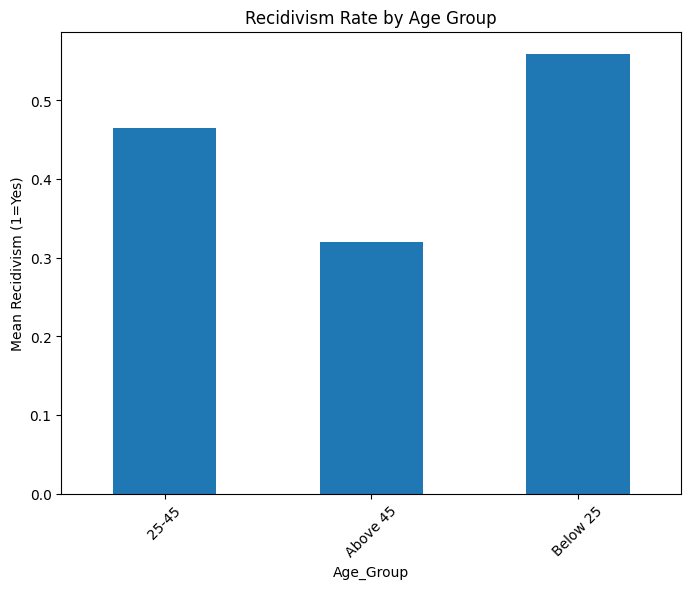

In [20]:
# Recidivism by Age Group
age_recid = df.groupby('Age_Group')['Two_yr_Recidivism'].mean()
print("--- Recidivism Rate by Age Group ---\n", age_recid)

plt.figure(figsize=(8, 6))
age_recid.plot(kind='bar')
plt.title("Recidivism Rate by Age Group")
plt.ylabel("Mean Recidivism (1=Yes)")
plt.xticks(rotation=45)
save_plot("recidivism_by_age_group.png")
plt.show()